Installing libraries

In [30]:
!pip install yfinance ta matplotlib pandas
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator, ROCIndicator
from ta.volatility import BollingerBands

Downloading Historical Data

In [33]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-06-01'

df = yf.download(ticker, start=start_date, end=end_date)
df.dropna(inplace=True)
df.describe()

/tmp/ipykernel_5882/4212410808.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed



Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,1360.000000,1360.000000,1360.000000,1360.000000,1.360000e+03
mean,157.032912,158.663163,155.214103,156.867179,8.817788e+07
std,44.396243,44.647029,44.056988,44.341920,5.238631e+07
min,54.378582,55.379535,51.528416,55.277744,2.323470e+07
25%,128.810146,130.446226,127.369737,129.085665,5.365702e+07
50%,155.734940,158.128826,153.380820,156.135451,7.419030e+07
75%,185.212910,186.577467,183.046276,185.029446,1.045730e+08
max,258.396667,259.474086,257.010028,257.568678,4.265100e+08


In [34]:
# --- Step 2: Clean Close Series ---
close = pd.Series(df['Close'].values.squeeze(), index=df.index)

In [35]:
# Moving Averages
df['SMA_20'] = SMAIndicator(close=close, window=20).sma_indicator()
df['EMA_50'] = EMAIndicator(close=close, window=50).ema_indicator()

# RSI
df['RSI'] = RSIIndicator(close=close, window=14).rsi()

# MACD
macd = MACD(close=close)
df['MACD'] = macd.macd()
df['MACD_signal'] = macd.macd_signal()

# Bollinger Bands
bb = BollingerBands(close=close, window=20, window_dev=2)
df['BB_upper'] = bb.bollinger_hband()
df['BB_lower'] = bb.bollinger_lband()

# Momentum (Rate of Change)
df['Momentum'] = ROCIndicator(close=close, window=10).roc()

In [36]:
print(df[['Close', 'SMA_20', 'EMA_50', 'RSI', 'MACD', 'MACD_signal', 'BB_upper', 'BB_lower', 'Momentum']].tail())

Price            Close      SMA_20      EMA_50        RSI      MACD  \
Ticker            AAPL                                                
Date                                                                  
2025-05-23  195.270004  205.631774  209.020720  38.828188 -1.065059   
2025-05-27  200.210007  205.149035  208.675202  44.869601 -1.301828   
2025-05-28  200.419998  204.623365  208.351468  45.117730 -1.455743   
2025-05-29  199.949997  204.009779  208.021999  44.633524 -1.597235   
2025-05-30  200.850006  203.400248  207.740744  45.832349 -1.618094   

Price      MACD_signal    BB_upper    BB_lower  Momentum  
Ticker                                                    
Date                                                      
2025-05-23   -0.380201  218.325728  192.937820 -1.513088  
2025-05-27   -0.564526  217.896574  192.401496 -5.019207  
2025-05-28   -0.742770  217.239839  192.006891 -5.875168  
2025-05-29   -0.913663  216.277239  191.742319 -5.830549  
2025-05-30   -1.05

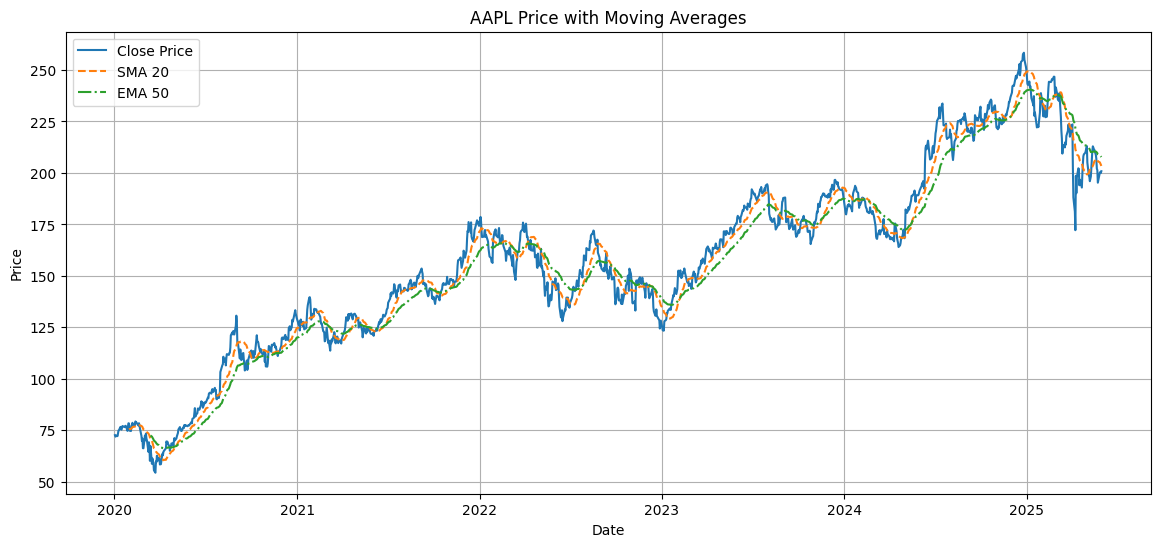

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['SMA_20'], label='SMA 20', linestyle='--')
plt.plot(df['EMA_50'], label='EMA 50', linestyle='-.')
plt.title('AAPL Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


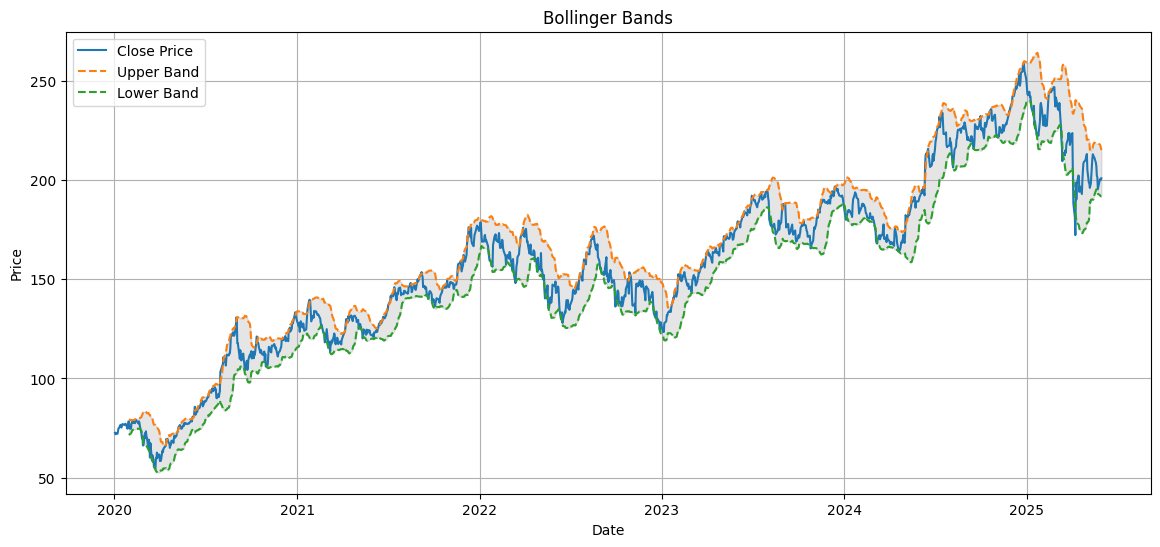

In [38]:
plt.figure(figsize=(14, 6))
plt.plot(df['Close'], label='Close Price', linewidth=1.5)
plt.plot(df['BB_upper'], label='Upper Band', linestyle='--')
plt.plot(df['BB_lower'], label='Lower Band', linestyle='--')
plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], color='gray', alpha=0.2)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


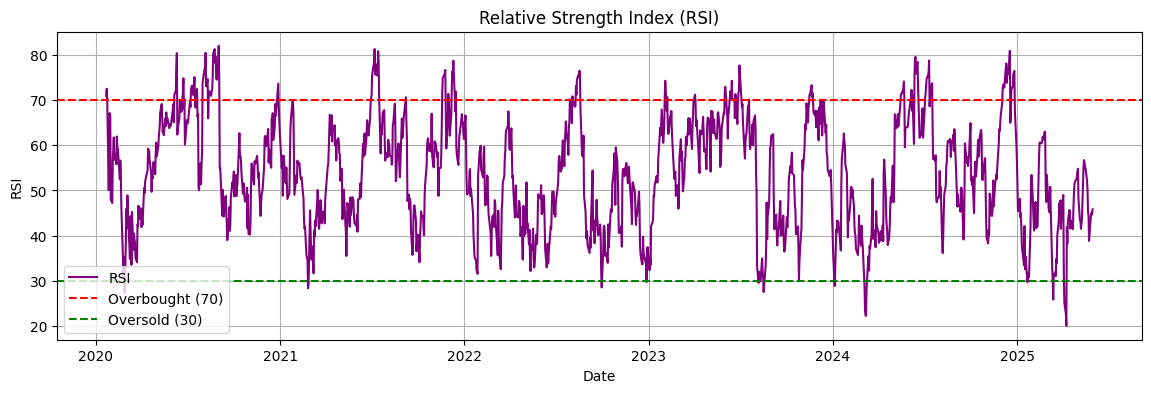

In [39]:
plt.figure(figsize=(14, 4))
plt.plot(df['RSI'], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()


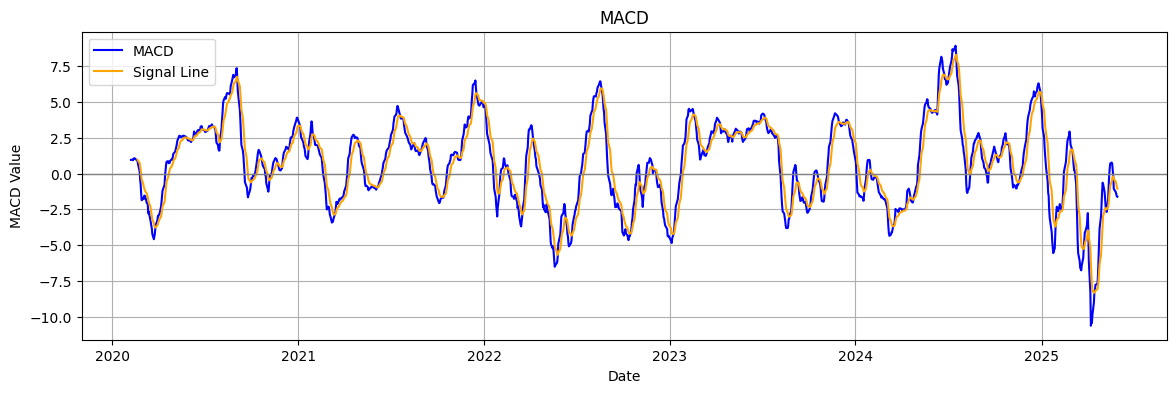

In [40]:
plt.figure(figsize=(14, 4))
plt.plot(df['MACD'], label='MACD', color='blue')
plt.plot(df['MACD_signal'], label='Signal Line', color='orange')
plt.axhline(0, color='gray', linewidth=1)
plt.title('MACD')
plt.xlabel('Date')
plt.ylabel('MACD Value')
plt.legend()
plt.grid(True)
plt.show()


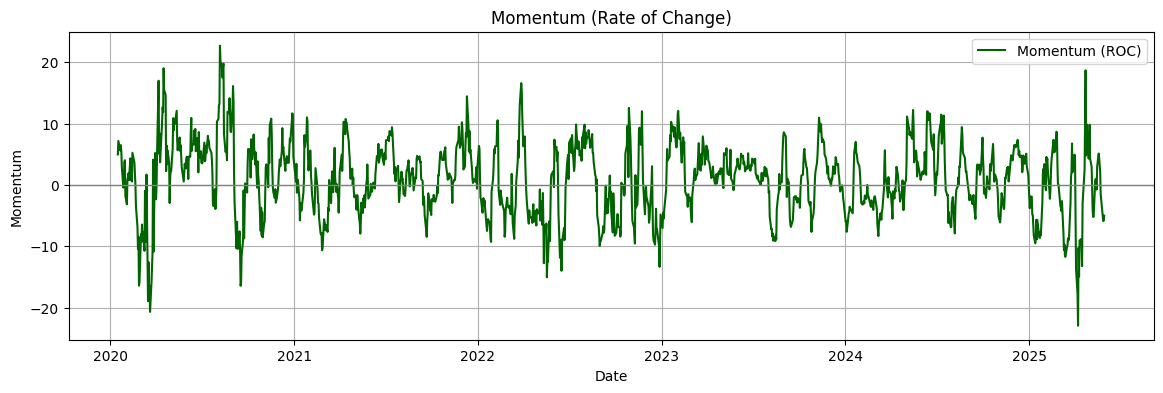

In [41]:
plt.figure(figsize=(14, 4))
plt.plot(df['Momentum'], label='Momentum (ROC)', color='darkgreen')
plt.axhline(0, color='gray', linewidth=1)
plt.title('Momentum (Rate of Change)')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)
plt.show()


In [29]:

from ta.trend import SMAIndicator

# Step 1: Download
df = yf.download('AAPL', start='2020-01-01', end='2025-06-01')
df.dropna(inplace=True)

# Step 2: Sanitize
close_series = pd.Series(df['Close'].values.squeeze(), index=df.index)

# Step 3: Apply SMA
sma = SMAIndicator(close=close_series, window=20)
df['SMA_20'] = sma.sma_indicator()

# Step 4: Verify
print(df[['Close', 'SMA_20']].tail())



/tmp/ipykernel_5882/3221385371.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2020-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

Price            Close      SMA_20
Ticker            AAPL            
Date                              
2025-05-23  195.270004  205.631774
2025-05-27  200.210007  205.149035
2025-05-28  200.419998  204.623365
2025-05-29  199.949997  204.009779
2025-05-30  200.850006  203.400248


In [25]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2025-06-1'

df = yf.download(ticker, start=start_date, end=end_date)
print(df.dtypes)
df.dropna(inplace=True)
df.head()

/tmp/ipykernel_5882/627908916.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price   Ticker
Close   AAPL      float64
High    AAPL      float64
Low     AAPL      float64
Open    AAPL      float64
Volume  AAPL        int64
dtype: object


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620842,72.681289,71.373218,71.627092,135480400
2020-01-03,71.914818,72.676447,71.689957,71.847118,146322800
2020-01-06,72.487846,72.526533,70.783248,71.034709,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307518,73.609752,71.849540,71.849540,132079200


In [27]:
from ta.trend import SMAIndicator
sma = SMAIndicator(close=df['Close'], window=20)
df['SMA_20'] = sma.sma_indicator()

ValueError: Data must be 1-dimensional, got ndarray of shape (1360, 1) instead

In [19]:

df['SMA_20'] = ta.trend.sma_indicator(df['Close'], window=20)
df['EMA_50'] = ta.trend.ema_indicator(df['Close'], window=50)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd(df['Close'])
df['MACD_Signal'] = ta.trend.macd_signal(df['Close'])
df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'], window=20, window_dev=2)
df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'], window=20, window_dev=2)       
df['Momentum'] = ta.momentum.roc(df['Close'], window=10)

ValueError: Data must be 1-dimensional, got ndarray of shape (1360, 1) instead